In [1]:

import os
from dotenv import load_dotenv, find_dotenv # do 'pip install python-dotenv'
from os.path import join, dirname, basename, exists, isdir
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
	pass
else:
	pass
	#mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


Load the three datasets

In [2]:

def integrate_experiments(row, col1_name, col2_name):
    '''
    Function to combine the results of the two repetitions 
    '''
    if row[col1_name] is True or row[col2_name] is True:
        return True

    elif row[col1_name] is False or row[col2_name] is False:
        return False
    
    elif pd.isna(row[col1_name]) and pd.isna(row[col2_name]):
        return np.nan

    else:
        raise ValueError


        
# get the experimental data
experiments_df = pd.read_csv(join(FINAL, 'experiments', '1.1.3.n_lysate_assay_summary_12.11.2018.tsv'), sep='\t')


# integrate the solubility results
experiments_df['soluble'] = experiments_df.apply(lambda row: integrate_experiments(row, col1_name='rep0_soluble', col2_name='rep1_soluble'), axis=1)

# integrate the activity results
experiments_df['active'] = experiments_df.apply(lambda row: integrate_experiments(row, col1_name='rep0_active', col2_name='rep1_active'), axis=1)


# make a subset
experiments_df = experiments_df.loc[:, ['node', 'synthesized', 'substrate_available', 'soluble', 'active']]

# rename the "node" to "uid"
colnames = list(experiments_df.columns)
colnames[0] = 'uid'
experiments_df.columns = colnames

experiments_df.head()


,uid,synthesized,substrate_available,soluble,active
0,A0A009NBJ7,True,True,False,NaN
1,A0A011R8E6,True,True,False,NaN
2,A0A017H745,True,True,False,NaN
3,A0A024H7W1,True,True,True,True
4,A0A073CBY9,True,True,True,True


In [3]:
# get the ph/temp/phylogeny data 
identifiers_df = pd.read_csv(join(FINAL, 'sequence_properties', 'uid_data.tsv'), sep='\t')

identifiers_df.head()

,uid,taxid,organism,superkingdom,ph,temperature,pfam,lineage_identifiers,lineage_ranks,lineage_names
0,B7N6P4,585056,Escherichia coli,Bacteria,7.01,36.0,PF01266,"1, 131567, 2, 1224, 1236, 91347, 543, 561, 562...","root, no rank, superkingdom, phylum, class, or...","root, cellular organisms, Bacteria, Proteobact..."
1,A0A0M7LBC1,134375,Achromobacter sp.,Bacteria,7.10,28.0,PF01266,"1, 131567, 2, 1224, 28216, 80840, 506, 222, 13...","root, no rank, superkingdom, phylum, class, or...","root, cellular organisms, Bacteria, Proteobact..."
2,A0A0U5XJG3,615,Serratia marcescens,Bacteria,7.07,29.0,NaN,"1, 131567, 2, 1224, 1236, 91347, 1903411, 613,...","root, no rank, superkingdom, phylum, class, or...","root, cellular organisms, Bacteria, Proteobact..."
3,Q6MTY6,272632,Mycoplasma mycoides,Bacteria,NaN,37.0,PF01266,"1, 131567, 2, 1783272, 544448, 31969, 2085, 20...","root, no rank, superkingdom, no rank, phylum, ...","root, cellular organisms, Bacteria, Terrabacte..."
4,A0A090SES2,990271,Vibrio variabilis,Bacteria,7.60,28.0,PF01266,"1, 131567, 2, 1224, 1236, 135623, 641, 662, 99...","root, no rank, superkingdom, phylum, class, or...","root, cellular organisms, Bacteria, Proteobact..."


In [4]:
# get uid to ec mapping
uid_ec_mapping_df = pd.read_csv(join(FINAL, 'sequence_properties', 'ec_uid_org_from_fasta.tsv'), sep='\t')

uid_ec_mapping_df.head()

,uid,ec
0,Q8J2V8,1.1.3.10
1,J7LQA3,1.1.3.10
2,I4EXQ4,1.1.3.10
3,Q0RGV3,1.1.3.10
4,I4EXS6,1.1.3.10


Now I have the data, time two join the data frames on uid identifier

In [5]:
two_data_df = pd.merge(uid_ec_mapping_df, identifiers_df, on=['uid'])

all_data_df = pd.merge(two_data_df, experiments_df, on=['uid'])

all_data_df.head()


,uid,ec,taxid,organism,superkingdom,ph,temperature,pfam,lineage_identifiers,lineage_ranks,lineage_names,synthesized,substrate_available,soluble,active
0,Q8J2V8,1.1.3.10,40145,Tricholoma matsutake,Eukaryota,6.05,23.0,NaN,"1, 131567, 2759, 33154, 4751, 451864, 5204, 53...","root, no rank, superkingdom, no rank, kingdom,...","root, cellular organisms, Eukaryota, Opisthoko...",False,NaN,NaN,NaN
1,I4EXQ4,1.1.3.10,477641,Modestobacter marinus,Bacteria,7.20,28.0,"PF00732, PF05199","1, 131567, 2, 1783272, 201174, 1760, 1643682, ...","root, no rank, superkingdom, no rank, phylum, ...","root, cellular organisms, Bacteria, Terrabacte...",True,True,False,NaN
2,J7LVS7,1.1.3.10,1118963,Arthrobacter sp.,Bacteria,7.15,29.0,"PF00732, PF05199","1, 131567, 2, 1783272, 201174, 1760, 85006, 12...","root, no rank, superkingdom, no rank, phylum, ...","root, cellular organisms, Bacteria, Terrabacte...",True,True,False,NaN
3,A0A0I9NPR5,1.1.3.10,573,Klebsiella pneumoniae,Bacteria,7.07,34.0,NaN,"1, 131567, 2, 1224, 1236, 91347, 543, 570, 573","root, no rank, superkingdom, phylum, class, or...","root, cellular organisms, Bacteria, Proteobact...",True,True,False,NaN
4,G4HXT0,1.1.3.10,931627,Mycolicibacterium rhodesiae,Bacteria,NaN,NaN,"PF01266, PF05199","1, 131567, 2, 1783272, 201174, 1760, 85007, 17...","root, no rank, superkingdom, no rank, phylum, ...","root, cellular organisms, Bacteria, Terrabacte...",True,True,False,NaN


#### Ok, now it's all there, time to start to do some plotting.

In [6]:
# Setup matplotlib parameters

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)


**Breakdown of what we ordered, archaea vs bacteria vs eukaryotes**

In [7]:
# Make the dataset

order_df = all_data_df.loc[:, ['uid', 'superkingdom']]
order_df = order_df.drop_duplicates()

order_df.head()

,uid,superkingdom
0,Q8J2V8,Eukaryota
1,I4EXQ4,Bacteria
2,J7LVS7,Bacteria
3,A0A0I9NPR5,Bacteria
4,G4HXT0,Bacteria


superkingdom
Archaea        7
Bacteria     144
Eukaryota     33
Name: uid, dtype: int64


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

/home/martin/.conda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


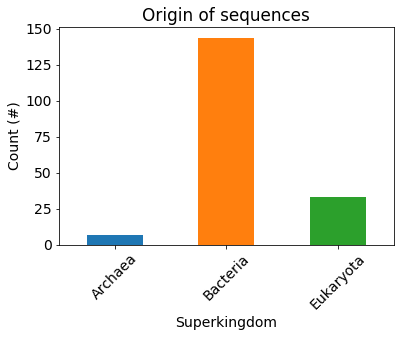

In [8]:
# Plot it

result = order_df.groupby('superkingdom')['uid'].nunique()

print(result)

p = result.plot(kind="bar", title='Origin of sequences')
p.set_xlabel("Superkingdom")
p.set_ylabel("Count (#)")
plt.xticks(rotation=45)


**What's the distribution of growth temperatures in this dataset**


In [9]:
# Make the dataset

temp_df = all_data_df.loc[:, ['superkingdom', 'temperature']]


# change to wide so I can get the superkingdom information in there
temp_df_wide = temp_df.pivot(columns='superkingdom',
           values='temperature')

temp_df_wide.head()

superkingdom,Archaea,Bacteria,Eukaryota
0,NaN,NaN,23.0
1,NaN,28.0,NaN
2,NaN,29.0,NaN
3,NaN,34.0,NaN
4,NaN,NaN,NaN


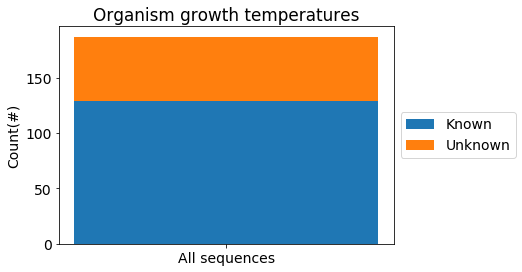

In [10]:
# Plot for how many I actually have the temperature
temp_df['temperature'].isna().sum() 




temp_df['temperature'].count() + temp_df['temperature'].isna().sum() 



known = temp_df['temperature'].count()
unknown = temp_df['temperature'].isna().sum()

p1 = plt.bar(0, (known), width=0.25, align='center')
p2 = plt.bar(0, (unknown), width=0.25, align='center', bottom=known)


plt.ylabel('Count(#)')
plt.title('Organism growth temperatures')
plt.xticks([0], ('All sequences', ))
plt.legend((p1[0], p2[0]), ('Known', 'Unknown'), loc='center left', bbox_to_anchor=(1.0, 0.5))



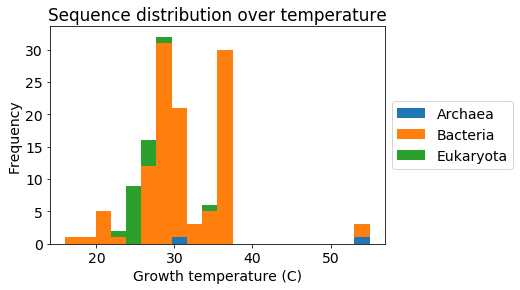

In [11]:
# Plot it

p = temp_df_wide.plot(kind='hist', title='Sequence distribution over temperature', bins=20, stacked=True)
p.set_xlabel("Growth temperature (C)")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

**What's the distribution of pH values in this dataset**

In [12]:
# Make the dataset

ph_df = all_data_df.loc[:, ['superkingdom', 'ph']]

# change to wide so I can get the superkingdom information in there
ph_df_wide = ph_df.pivot(columns='superkingdom',
           values='ph')

ph_df_wide.head()

superkingdom,Archaea,Bacteria,Eukaryota
0,NaN,NaN,6.05
1,NaN,7.20,NaN
2,NaN,7.15,NaN
3,NaN,7.07,NaN
4,NaN,NaN,NaN


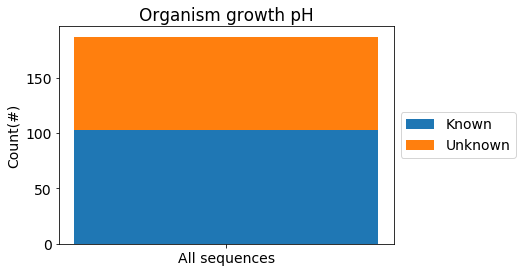

In [13]:
# Plot for how many I actually have the temperature
ph_df['ph'].isna().sum() 




ph_df['ph'].count() + ph_df['ph'].isna().sum() 



known = ph_df['ph'].count()
unknown = ph_df['ph'].isna().sum()

p1 = plt.bar(0, (known), width=0.25, align='center')
p2 = plt.bar(0, (unknown), width=0.25, align='center', bottom=known)


plt.ylabel('Count(#)')
plt.title('Organism growth pH')
plt.xticks([0], ('All sequences', ))
plt.legend((p1[0], p2[0]), ('Known', 'Unknown'), loc='center left', bbox_to_anchor=(1.0, 0.5))



Text(0.5,0,'Growth pH')

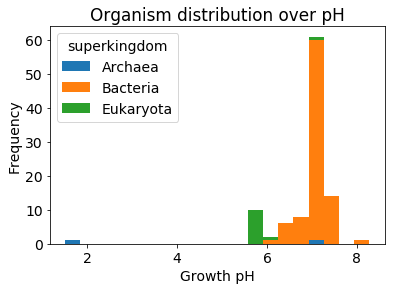

In [14]:
# Plot it

p = ph_df_wide.plot(kind='hist', title='Organism distribution over pH', bins=20, stacked=True)
p.set_xlabel("Growth pH")

**What about the distribution between ec numbers?**

In [15]:
# Make the dataset
enzyme_df = all_data_df.loc[:, ['uid', 'ec', 'superkingdom']]
enzyme_df = enzyme_df.drop_duplicates()

enzyme_df.head()

,uid,ec,superkingdom
0,Q8J2V8,1.1.3.10,Eukaryota
1,I4EXQ4,1.1.3.10,Bacteria
2,J7LVS7,1.1.3.10,Bacteria
3,A0A0I9NPR5,1.1.3.10,Bacteria
4,G4HXT0,1.1.3.10,Bacteria


**Assemble a dataset to look at solubility and activity**


In [16]:
# Make the dataset
all_exp_df = all_data_df.loc[:, ['uid', 'ec', 'superkingdom', 'synthesized', 'soluble', 'active']]

# replace the nan value, True and False
all_exp_df = all_exp_df.fillna('Untested')

all_exp_df['synthesized'] = all_exp_df['synthesized'].replace(False, 'Not_synthesized')
all_exp_df['synthesized'] = all_exp_df['synthesized'].replace(True, 'Synthesized')

all_exp_df['soluble'] = all_exp_df['soluble'].replace(False, 'Insoluble')
all_exp_df['soluble'] = all_exp_df['soluble'].replace(True, 'Soluble')

all_exp_df['active'] = all_exp_df['active'].replace(False, 'Inactive')
all_exp_df['active'] = all_exp_df['active'].replace(True, 'Active')


all_exp_df.head()

,uid,ec,superkingdom,synthesized,soluble,active
0,Q8J2V8,1.1.3.10,Eukaryota,Not_synthesized,Untested,Untested
1,I4EXQ4,1.1.3.10,Bacteria,Synthesized,Insoluble,Untested
2,J7LVS7,1.1.3.10,Bacteria,Synthesized,Insoluble,Untested
3,A0A0I9NPR5,1.1.3.10,Bacteria,Synthesized,Insoluble,Untested
4,G4HXT0,1.1.3.10,Bacteria,Synthesized,Insoluble,Untested


**First look at vs insoluble protein**

synthesized
Synthesized    183
Name: uid, dtype: int64


/home/martin/.conda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


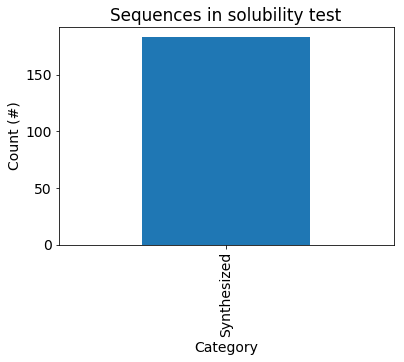

In [17]:
# Plot it
df_subset = all_exp_df.loc[all_exp_df['synthesized']=='Synthesized']
result = df_subset.groupby('synthesized')['uid'].nunique()
result.sort_values(ascending=False, inplace=True)

print(result)

p = result.plot(kind="bar", title='Sequences in solubility test')
p.set_xlabel("Category")
p.set_ylabel("Count (#)")

# save the index for downstream plots
my_index = result.index

soluble      Insoluble   Soluble  Untested
synthesized                               
Synthesized   0.553763  0.403226  0.043011


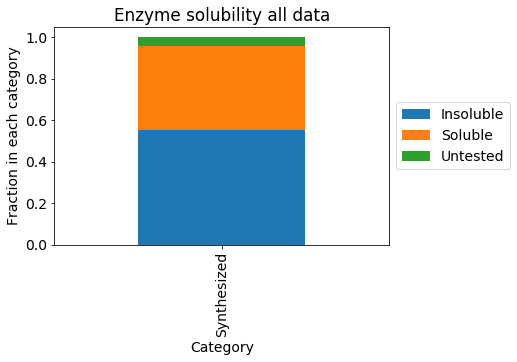

In [18]:
# The same data as a fraction

# calculate the fraction
df_subset = all_exp_df.loc[all_exp_df['synthesized']=='Synthesized']
result = df_subset.groupby('synthesized')['soluble'].value_counts(normalize=True)
result = result.unstack().fillna(0)
print(result)

p = result.plot(kind="bar", title='Enzyme solubility all data', stacked=True)
p.set_xlabel("Category")
p.set_ylabel("Fraction in each category")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

soluble
Insoluble    103
Soluble       73
Untested       7
Name: uid, dtype: int64


Text(0,0.5,'Count (#)')

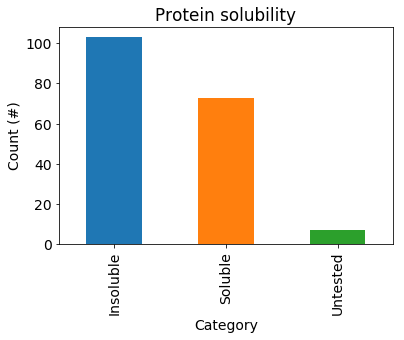

In [19]:
# Plot it
df_subset = all_exp_df.loc[all_exp_df['synthesized']=='Synthesized']
result = df_subset.groupby('soluble')['uid'].nunique()

result.sort_values(ascending=False, inplace=True)

print(result)

p = result.plot(kind="bar", title='Protein solubility')
p.set_xlabel("Category")
p.set_ylabel("Count (#)")

superkingdom
Archaea        7
Bacteria     144
Eukaryota     32
Name: uid, dtype: int64


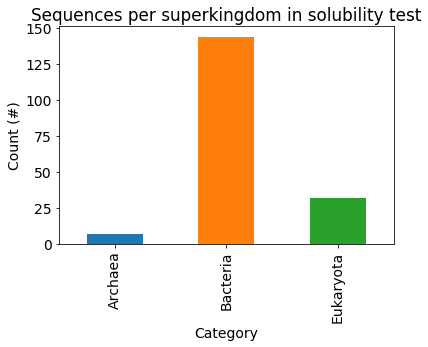

In [20]:
# how many do we actually have in each of the categories
df_subset = all_exp_df.loc[all_exp_df['synthesized']=='Synthesized']
result = df_subset.groupby('superkingdom')['uid'].nunique()
result = result.fillna(0)

print(result)

p = result.plot(kind="bar", title='Sequences per superkingdom in solubility test', stacked=False)
p.set_xlabel("Category")
p.set_ylabel("Count (#)")

# save the index for downstream plots
my_index = result.index

soluble       Insoluble   Soluble  Untested
superkingdom                               
Archaea        0.428571  0.571429  0.000000
Bacteria       0.530612  0.421769  0.047619
Eukaryota      0.687500  0.281250  0.031250


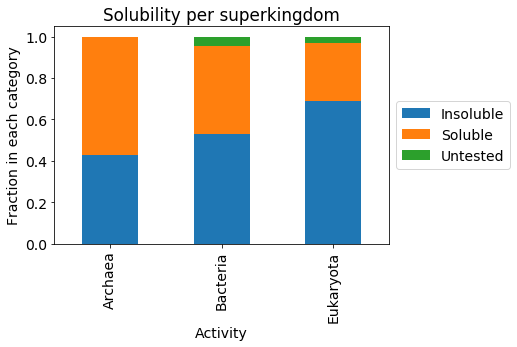

In [21]:
# Active vs inactive for each superkingdom, as fraction

# count calculate the fraction
df_subset = all_exp_df.loc[all_exp_df['synthesized']=='Synthesized']
result = df_subset.groupby('superkingdom')['soluble'].value_counts(normalize=True)
result = result.unstack().fillna(0)

# sort bast on previous index
result = result.reindex(my_index)
print(result)

p = result.plot(kind="bar", title='Solubility per superkingdom', stacked=True)
p.set_xlabel("Activity")
p.set_ylabel("Fraction in each category")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

ec
1.1.3.15    74
1.1.3.8     21
1.1.3.6     19
1.1.3.21    14
1.1.3.9      9
1.1.3.41     7
1.1.3.10     5
1.1.3.43     4
1.1.3.37     4
1.1.3.20     4
1.1.3.17     4
1.1.3.13     4
1.1.3.12     3
1.1.3.4      2
1.1.3.38     2
1.1.3.7      2
1.1.3.47     1
1.1.3.45     1
1.1.3.44     1
1.1.3.42     1
1.1.3.48     1
1.1.3.5      1
Name: uid, dtype: int64


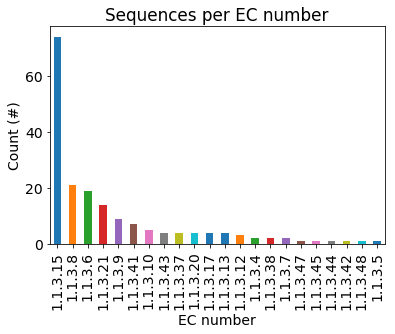

In [22]:
# Plot it
df_subset = all_exp_df.loc[all_exp_df['synthesized']=='Synthesized']
result = df_subset.groupby('ec')['uid'].nunique()

result.sort_values(ascending=False, inplace=True)

print(result)

p = result.plot(kind="bar", title='Sequences per EC number')
p.set_xlabel("EC number")
p.set_ylabel("Count (#)")

# save the index for downstream plots
my_index = result.index

soluble   Insoluble   Soluble  Untested
ec                                     
1.1.3.15   0.413333  0.586667       0.0
1.1.3.8    0.714286  0.285714       0.0
1.1.3.6    0.842105  0.157895       0.0
1.1.3.21   0.500000  0.500000       0.0
1.1.3.9    1.000000  0.000000       0.0
1.1.3.41   0.571429  0.428571       0.0
1.1.3.10   1.000000  0.000000       0.0
1.1.3.43   0.000000  0.000000       1.0
1.1.3.37   0.500000  0.500000       0.0
1.1.3.20   1.000000  0.000000       0.0
1.1.3.17   0.000000  1.000000       0.0
1.1.3.13   0.600000  0.400000       0.0
1.1.3.12   1.000000  0.000000       0.0
1.1.3.4    1.000000  0.000000       0.0
1.1.3.38   0.000000  1.000000       0.0
1.1.3.7    0.500000  0.500000       0.0
1.1.3.47   1.000000  0.000000       0.0
1.1.3.45   0.000000  0.000000       1.0
1.1.3.44   0.000000  0.000000       1.0
1.1.3.42   0.000000  0.000000       1.0
1.1.3.48   0.000000  0.000000       1.0
1.1.3.5    0.000000  1.000000       0.0


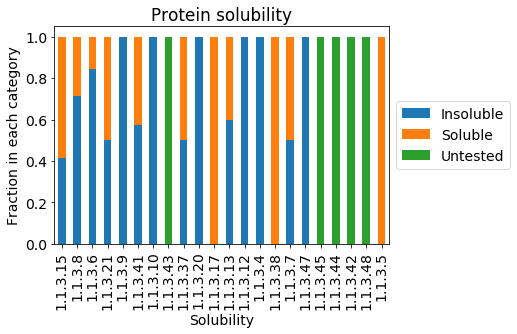

In [23]:
# Soluble vs insoluble for each EC, as a fracation

# count calculate the fraction
df_subset = all_exp_df.loc[all_exp_df['synthesized']=='Synthesized']
result = df_subset.groupby('ec')['soluble'].value_counts(normalize=True)
result = result.unstack().fillna(0)

# sort bast on previous index
result = result.reindex(my_index)
print(result)

p = result.plot(kind="bar", title='Protein solubility', stacked=True)
p.set_xlabel("Solubility")
p.set_ylabel("Fraction in each category")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


**Now let's look at the activity of the soluble ones**


soluble
Soluble    73
Name: uid, dtype: int64


Text(0,0.5,'Count (#)')

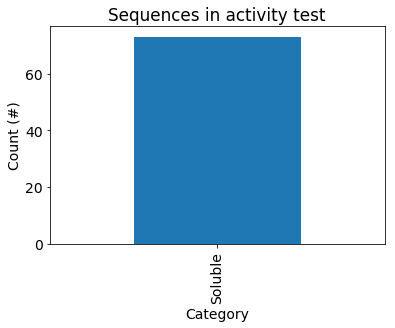

In [24]:
# Plot it
df_subset = all_exp_df.loc[all_exp_df['soluble']=='Soluble']
result = df_subset.groupby('soluble')['uid'].nunique()
result.sort_values(ascending=False, inplace=True)

print(result)

p = result.plot(kind="bar", title='Sequences in activity test')
p.set_xlabel("Category")
p.set_ylabel("Count (#)")


active     Active  Inactive
soluble                    
Soluble  0.626667  0.373333


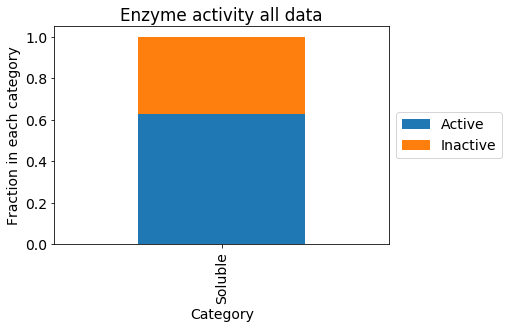

In [25]:
# The same data as a fraction

# count calculate the fraction
df_subset = all_exp_df.loc[all_exp_df['soluble']=='Soluble']
result = df_subset.groupby('soluble')['active'].value_counts(normalize=True)
result = result.unstack().fillna(0)


print(result)

p = result.plot(kind="bar", title='Enzyme activity all data', stacked=True)
p.set_xlabel("Category")
p.set_ylabel("Fraction in each category")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

active
Active      47
Inactive    26
Name: uid, dtype: int64


Text(0,0.5,'Count (#)')

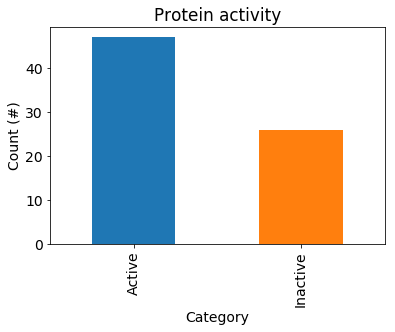

In [26]:
# Plot it
df_subset = all_exp_df.loc[all_exp_df['soluble']=='Soluble']
result = df_subset.groupby('active')['uid'].nunique()

result.sort_values(ascending=False, inplace=True)

print(result)

p = result.plot(kind="bar", title='Protein activity')
p.set_xlabel("Category")
p.set_ylabel("Count (#)")

superkingdom
Archaea       4
Bacteria     60
Eukaryota     9
Name: uid, dtype: int64


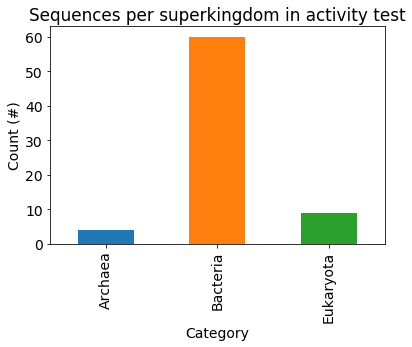

In [27]:
# how many do we actually have in each of the categories
df_subset = all_exp_df.loc[all_exp_df['soluble']=='Soluble']
result = df_subset.groupby('superkingdom')['uid'].nunique()
result = result.fillna(0)

print(result)

p = result.plot(kind="bar", title='Sequences per superkingdom in activity test', stacked=False)
p.set_xlabel("Category")
p.set_ylabel("Count (#)")

# save the index for downstream plots
my_index = result.index

active          Active  Inactive
superkingdom                    
Archaea       0.500000  0.500000
Bacteria      0.629032  0.370968
Eukaryota     0.666667  0.333333


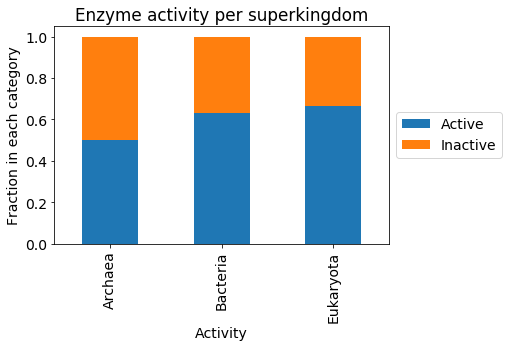

In [28]:
# Active vs inactive for each superkingdom, as fraction

# count calculate the fraction
df_subset = all_exp_df.loc[all_exp_df['soluble']=='Soluble']
result = df_subset.groupby('superkingdom')['active'].value_counts(normalize=True)
result = result.unstack().fillna(0)

# sort bast on previous index
result = result.reindex(my_index)
print(result)

p = result.plot(kind="bar", title='Enzyme activity per superkingdom', stacked=True)
p.set_xlabel("Activity")
p.set_ylabel("Fraction in each category")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

ec
1.1.3.15    43
1.1.3.21     7
1.1.3.8      6
1.1.3.17     4
1.1.3.6      3
1.1.3.41     3
1.1.3.38     2
1.1.3.37     2
1.1.3.7      1
1.1.3.5      1
1.1.3.13     1
Name: uid, dtype: int64


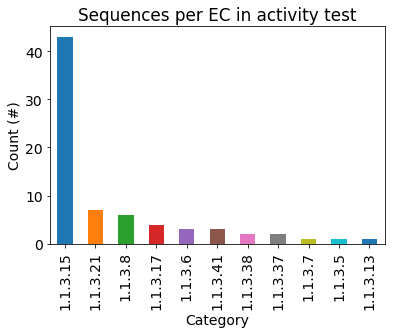

In [29]:
# how many do we actually have in each of the categories
df_subset = all_exp_df.loc[all_exp_df['soluble']=='Soluble']
result = df_subset.groupby('ec')['uid'].nunique()
result = result.fillna(0)
result.sort_values(ascending=False, inplace=True)
print(result)

p = result.plot(kind="bar", title='Sequences per EC in activity test', stacked=False)
p.set_xlabel("Category")
p.set_ylabel("Count (#)")

# save the index for downstream plots
my_index = result.index

active      Active  Inactive
ec                          
1.1.3.15  0.681818  0.318182
1.1.3.21  0.714286  0.285714
1.1.3.8   0.000000  1.000000
1.1.3.17  0.750000  0.250000
1.1.3.6   0.666667  0.333333
1.1.3.41  1.000000  0.000000
1.1.3.38  0.500000  0.500000
1.1.3.37  0.500000  0.500000
1.1.3.7   1.000000  0.000000
1.1.3.5   1.000000  0.000000
1.1.3.13  0.000000  1.000000


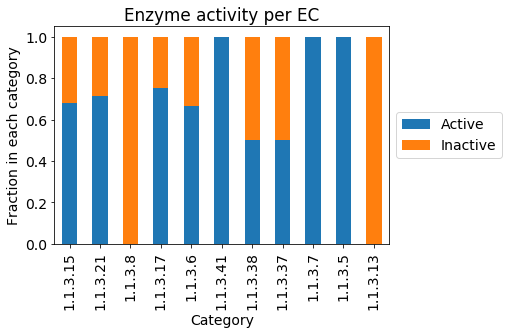

In [30]:
# Active vs inactive for each ec, as fraction

# count calculate the fraction
df_subset = all_exp_df.loc[all_exp_df['soluble']=='Soluble']
result = df_subset.groupby('ec')['active'].value_counts(normalize=True)
result = result.unstack().fillna(0)

# sort bast on previous index
result = result.reindex(my_index)
print(result)

# make the plot
p = result.plot(kind="bar", title='Enzyme activity per EC', stacked=True)
p.set_xlabel("Category")
p.set_ylabel("Fraction in each category")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
